In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
import math
import torch
import time
import re
import cv2
import shutil
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms
from icecream import ic
import tensorflow as tf 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
np.set_printoptions(precision=2,suppress=True)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(device_type='GPU', devices=gpus[0])

In [5]:
def plot_series(time, series, start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], label=label)
    plt.xlabel("time")
    plt.ylabel("value")
    if label:
        plt.legend(fontsize=14)
    plt.grid = True

<Figure size 720x432 with 0 Axes>

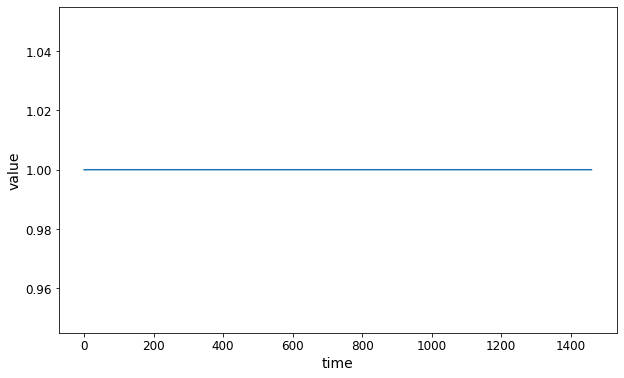

In [6]:
time = np.arange(4  * 365 + 1)
series = np.ones(4 * 365 + 1)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
def trend(time, slope=0):
    return slope * time

<Figure size 720x432 with 0 Axes>

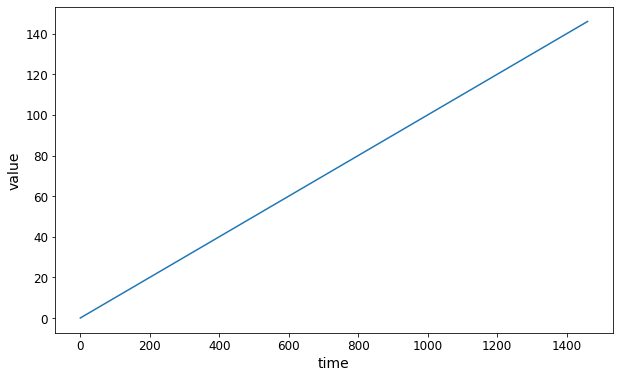

In [9]:
series = trend(time, 0.1)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# 周期性

In [12]:
def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time)
    )
def seasonality(time, period, amplititude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplititude * seasonal_pattern(season_time)

array([40.  , 39.99, 39.98, ...,  2.02,  2.01, 40.  ])

<Figure size 720x432 with 0 Axes>

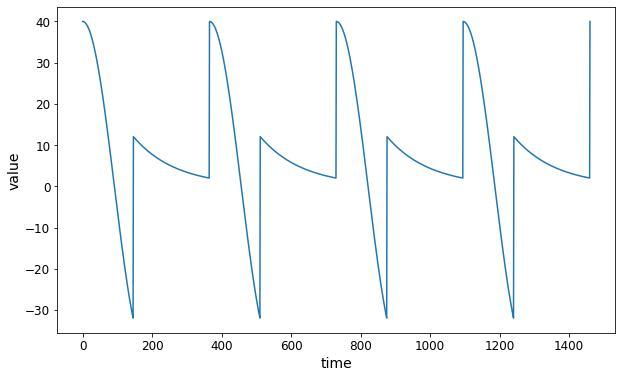

In [15]:
series = seasonality(time, period=365, amplititude=40)
series
plt.figure(figsize=(10, 6))
plot_series(time, series)

# 周期+趋势

<Figure size 720x432 with 0 Axes>

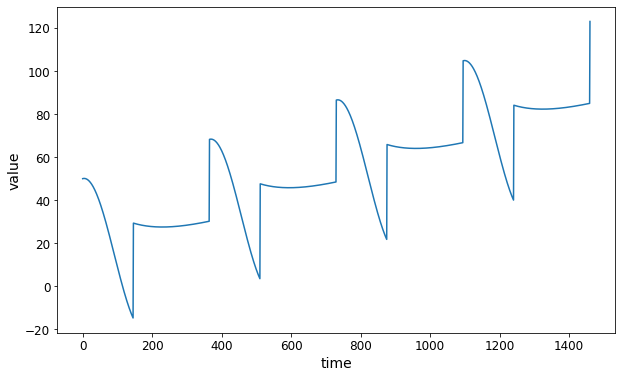

In [16]:
slope = 0.05
baseline = 10
series = baseline + trend(time, slope) + seasonality(time, period=365, amplititude=40)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [17]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

<Figure size 720x432 with 0 Axes>

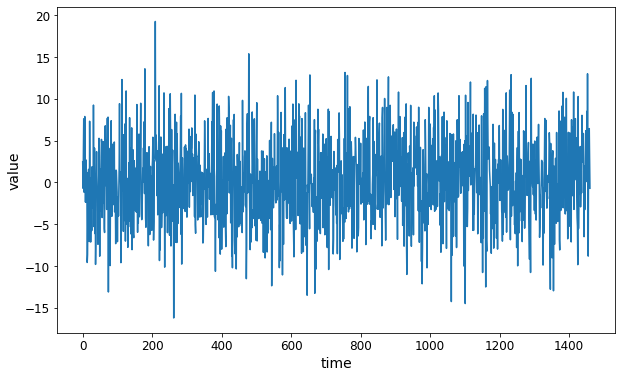

In [23]:
noise = white_noise(time, noise_level=5, seed=42)
plt.figure(figsize=(10, 6))
plot_series(time, noise)

# 白噪声加入序列

<Figure size 720x432 with 0 Axes>

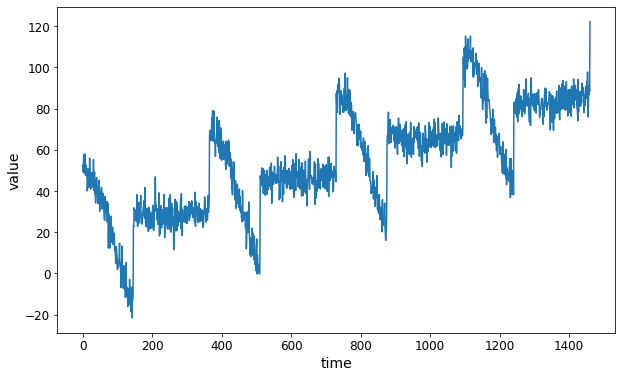

In [24]:
series += noise
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [25]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

<Figure size 720x432 with 0 Axes>

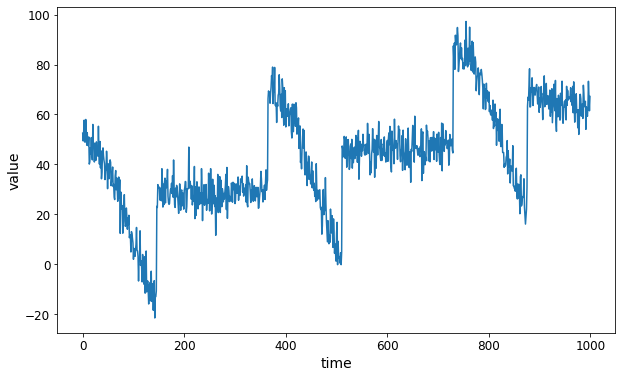

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)

<Figure size 720x432 with 0 Axes>

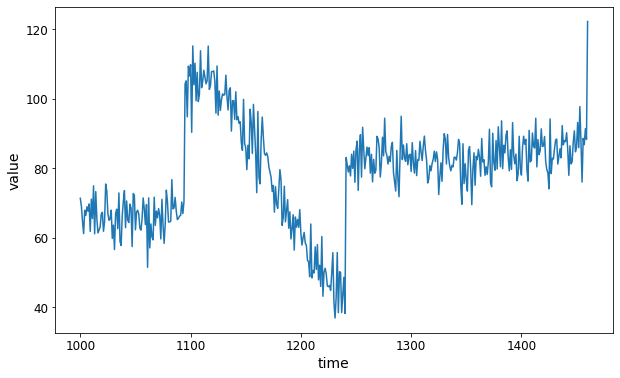

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

# 简单的预测

In [29]:
native_forecst = series[split_time - 1:-1]

<Figure size 720x432 with 0 Axes>

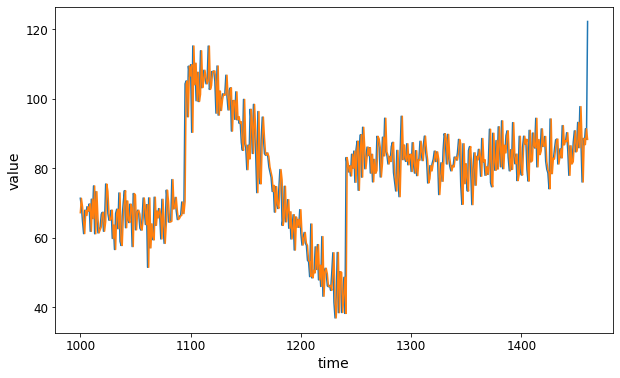

In [30]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, native_forecst)

## 放大验证集的开始部分

<Figure size 720x432 with 0 Axes>

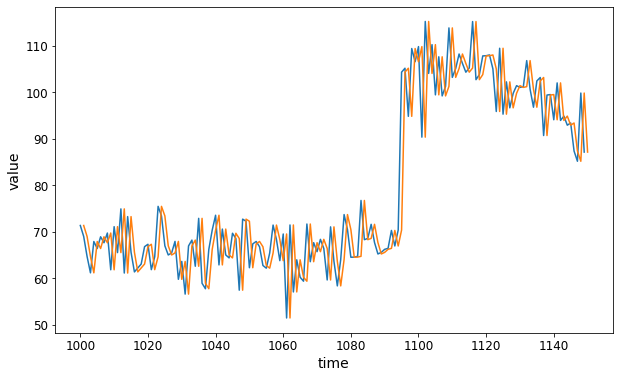

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, native_forecst, start=1, end=151)

In [37]:
import tensorflow as tf 

In [61]:
a = tf.keras.metrics.mean_squared_error(x_valid, native_forecst).numpy()
b = tf.keras.metrics.mean_absolute_error(x_valid, native_forecst).numpy()
a, b

(61.82753366856369, 5.9379085153216735)

## 滑动平均法

In [42]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series)-window_size):
        forecast.append(series[time: time + window_size].mean())
    return np.array(forecast)

In [59]:
moving_avg = moving_average_forecast(series, 30)[split_time-30:]
len(series), len(moving_avg), split_time, type(moving_avg), moving_avg.shape, len(x_valid), len(time_valid)

(1461, 461, 1000, numpy.ndarray, (461,), 461, 461)

<Figure size 720x432 with 0 Axes>

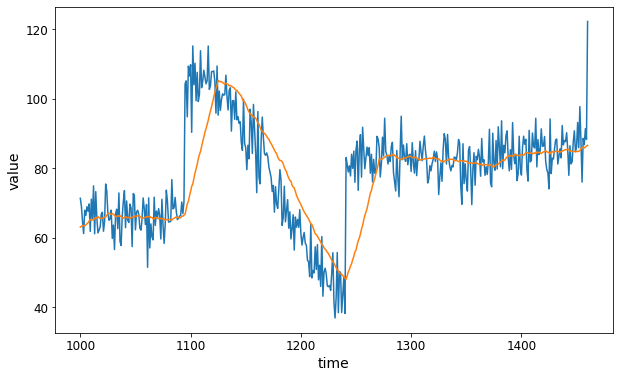

In [60]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [62]:
a = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
b = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
a, b

(106.67456651431165, 7.142418570620879)

In [63]:
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

<Figure size 720x432 with 0 Axes>

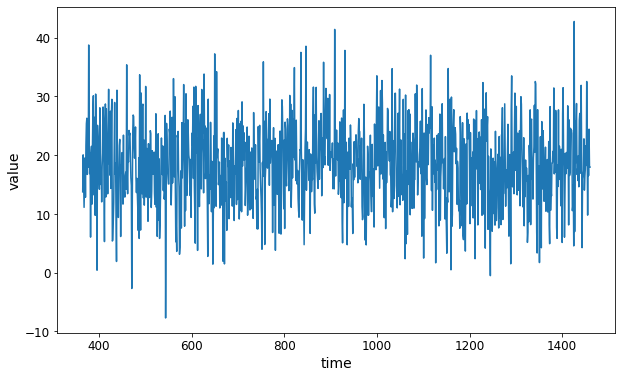

In [64]:
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)


In [70]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time-365-50:]
len(diff_series), len(diff_moving_avg)

(1096, 461)

<Figure size 720x432 with 0 Axes>

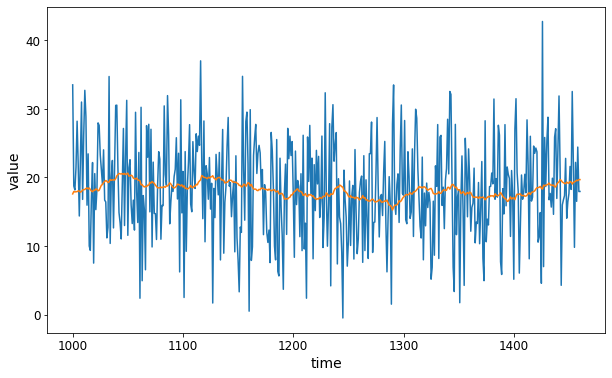

In [69]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time-365:])
plot_series(time_valid, diff_moving_avg)

In [71]:
diff_moving_avg_plus_last = series[split_time-365:-365] + diff_moving_avg

<Figure size 720x432 with 0 Axes>

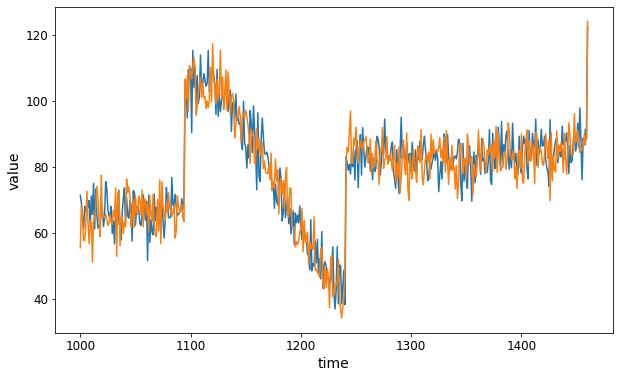

In [72]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_last)

In [73]:
a = tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_last).numpy()
b = tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_last).numpy()
a, b

(52.97365999969186, 5.839310562995894)

In [76]:
diff_moving_avg_plus_last_smooth = moving_average_forecast(series[split_time -370: -360], 10) + diff_moving_avg
len(diff_moving_avg_plus_last_smooth), len(series[split_time - 370 : -360]), len(diff_moving_avg)

(461, 471, 461)

In [80]:
diff_moving_avg_plus_last_smooth = moving_average_forecast(series[split_time -365 - 10: -365], 10) + diff_moving_avg
len(diff_moving_avg_plus_last_smooth), len(series[split_time - 370 : -360]), len(diff_moving_avg)

(461, 471, 461)

<Figure size 720x432 with 0 Axes>

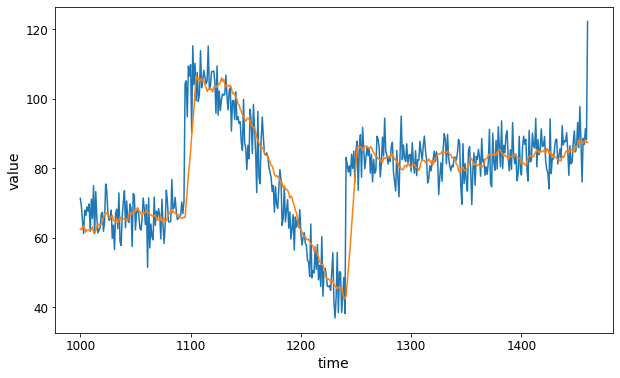

In [81]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_last_smooth)

# 预测

In [89]:
def trend(time, slope=0):
    return slope * time
def plot_series(time, series, start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], label=label)
    plt.xlabel("time")
    plt.ylabel("value")
    if label:
        plt.legend(fontsize=14)
    plt.grid = True
def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time)
    )
def seasonality(time, period, amplititude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplititude * seasonal_pattern(season_time)
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series)-window_size):
        forecast.append(series[time: time + window_size].mean())
    return np.array(forecast)

In [85]:
time = np.arange(365*4+1)
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5


In [88]:
series = (
    baseline + trend(time, slope) + seasonality(time, period=365, amplititude=amplitude)
)
series += white_noise(time, noise_level, seed=42)

<Figure size 720x432 with 0 Axes>

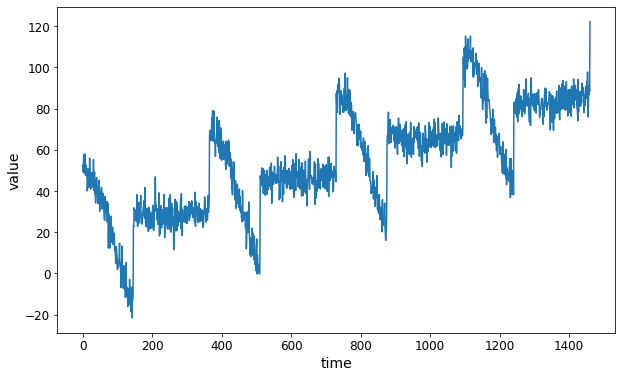

In [90]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
